In [74]:
import cv2 as cv
import numpy as np
import os
import shutil
import torch
import random
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision.transforms import functional as F

from torch import nn
from tqdm import tqdm
from io import BytesIO

#Para solucionar un posible problema con plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Empezamos recortando las imagenes del dataset por el centroide de la figura

In [75]:
def filter_image(image, debug = 0):
    #Pasamos la imagen a una escala de grises
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #Aplicamos un filtro gausiano para eliminar ruido
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    #Convertimos la imagen a blanco y negro
    ret, thresh = cv.threshold(blur, 75, 255, cv.THRESH_BINARY_INV)
    #Mostramos la imagen si es necesario
    if debug != 0:
        cv.imwrite("filter.png", thresh)
    return ret, thresh

def centroid(image, debug = 0):
    #Encontramos todos los contornos
    contours, hierarchies = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) != 0:  
        #Escogemos el contorno con mayor area
        c = max(contours, key = cv.contourArea)
        #Realizamos el cálculo de los centroides
        M = cv.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if debug != 0:
                print(f"x: {cx} y: {cy}")
    return cx, cy

In [76]:
def crop(path, new_path, type):
    i = 0
    for item in os.listdir(path):
        if os.path.isfile(os.path.join(path, item)):
            image = cv.imread(os.path.join(path, item))
            if image is not None:
                ret, thresh = filter_image(image)
                cx, cy = centroid(thresh)
                w = 215
                imageOut = image[cy-w:cy+w+1, cx-w:cx+w+1]
                #Renombramos los archivos
                name = str(i) + "_" + type + ".png"
                i = i + 1
                try:
                    cv.imwrite(os.path.join(new_path, name), imageOut)
                except:
                    continue

In [77]:
no_fail_path = "Dataset/Original/Sin Fallo"
fail_path = "Dataset/Original/Con Fallo"

new_no_fail_path =  "Dataset/Cortado/Sin Fallo"
new_fail_path =  "Dataset/Cortado/Con Fallo"

if os.path.exists(new_no_fail_path): shutil.rmtree(new_no_fail_path)
os.makedirs(new_no_fail_path)

if os.path.exists(new_fail_path): shutil.rmtree(new_fail_path)
os.makedirs(new_fail_path)

crop(no_fail_path, new_no_fail_path, "nofail")
crop(fail_path, new_fail_path, "fail")

In [78]:
#Comprobamos si disponemos de GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


### Una vez preparado el dataset lo dividimos en entrenamiento, validacion y test

In [79]:
def split_data(dataset, test_size=.2):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    first_split, second_split = random_split(dataset, lengths=[n_first, n_second])
    return first_split, second_split

In [80]:
DATASET_PATH = "Dataset/Cortado"

dataset = torchvision.datasets.ImageFolder(DATASET_PATH)

training_dataset, validation_dataset = split_data(dataset, test_size = 0.2)
training_dataset, test_dataset = split_data(training_dataset, test_size = 0.1)

In [81]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

In [82]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [83]:
batch_size = 32

transform = transforms.Compose([
                                transforms.Resize((200,200)),
                                transforms.RandomRotation(15),
                                transforms.RandomHorizontalFlip(30),
                                transforms.ToTensor(),
                               ])

training_dataset = SubsetTransforms(training_dataset, transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


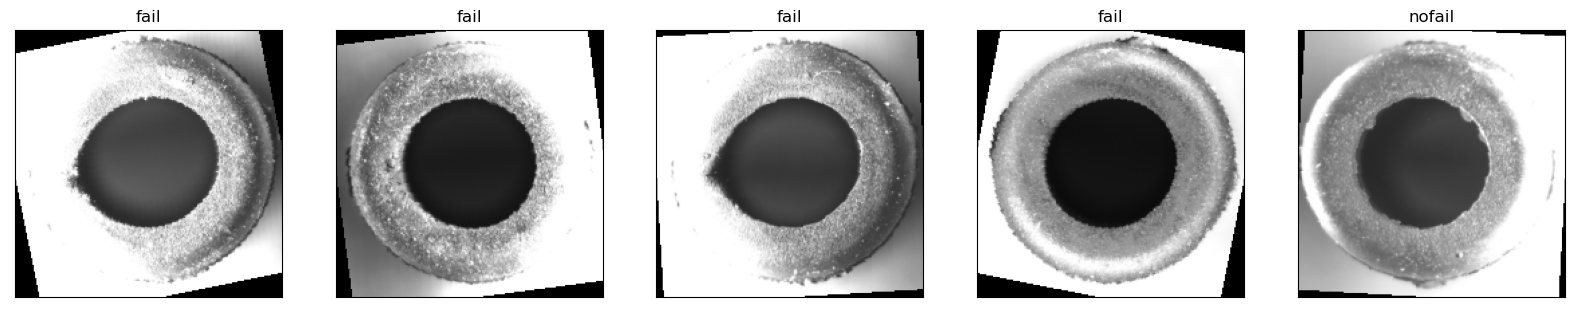

In [84]:
labels_to_idx = {"nofail":1, "fail":0}
idx_to_labels = {0: "fail", 1: "nofail"}

show(training_dataset, labels=idx_to_labels)

### Provisional ResNet18

In [85]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 2)

        unfreeze = ['layer4', 'fc']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False
    
    def forward(self, x):
        return self.model(x)

In [86]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [87]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [88]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
def test(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(test_loader.dataset), accuracy))

In [89]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/2205 (0%)]	Loss: 0.715773

Validation set: Average loss: 0.0477, Accuracy: 601/612 (98%)

Train Epoch: 2 [0/2205 (0%)]	Loss: 0.002383

Validation set: Average loss: 0.0173, Accuracy: 608/612 (99%)

Train Epoch: 3 [0/2205 (0%)]	Loss: 0.064814

Validation set: Average loss: 0.0291, Accuracy: 609/612 (100%)

Train Epoch: 4 [0/2205 (0%)]	Loss: 0.006100

Validation set: Average loss: 0.0281, Accuracy: 607/612 (99%)

Train Epoch: 5 [0/2205 (0%)]	Loss: 0.027265

Validation set: Average loss: 0.0229, Accuracy: 605/612 (99%)

Train Epoch: 6 [0/2205 (0%)]	Loss: 0.005999

Validation set: Average loss: 0.0096, Accuracy: 610/612 (100%)

Train Epoch: 7 [0/2205 (0%)]	Loss: 0.128139

Validation set: Average loss: 0.0053, Accuracy: 611/612 (100%)

Train Epoch: 8 [0/2205 (0%)]	Loss: 0.001366

Validation set: Average loss: 0.0160, Accuracy: 608/612 (99%)

Train Epoch: 9 [0/2205 (0%)]	Loss: 0.002677

Validation set: Average loss: 0.0076, Accuracy: 611/612 (100%)

Train Epoch: 10 [0/2205 

In [90]:
losst, acct = [], []
a = 10
for a in range(1, a + 1):
    test(losst, acct)

NameError: name 'test' is not defined